# CalcZernikes from DonutStamps

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2024-01-04**
<br>Software Versions:
  - `ts_wep`: **v8.0.3**
  - `lsst_distrib`: **w_2023_47**

## Notebook Objective

This notebooks shows how to calculate Zernike polynomial coefficient from a pair of `donutStampsExtra` and `donutStampsIntra` cut out from intra and extra-focal images. It walks through the available configuration settings and shows how to run it from the command line as part of a Gen 3 middleware pipeline. 

## Logistics

This notebook is intended to be run on the USDF RSP: https://usdf-rsp.slac.stanford.edu/.

### Data

The donut stamps for this notebook were created by `CutOutDonutsCwfsTask` from imSim simulations of the LSSTCam Corner Wavefront Sensors (CWFS) and stored in the shared AOS butler repository (`/sdf/group/rubin/repo/aos_imsim`). The collection with the data used in this notebook is `u/brycek/ts_analysis_notebooks/wep_v8.0.3`. The raw images and the Gaia DR2 reference catalog (`gaia_dr2_20200414`) used to generate the images are available for access in the same butler on the USDF. For more information on `CutOutDonutsCwfsTask` see the notebook [cutOutDonutsWithWep](cutOutDonutsWithWEP.ipynb). 

## Imports

In [1]:
import yaml
from copy import copy
from astropy.io import fits
from lsst.daf.butler import Butler

from lsst.ts.wep.utils import runProgram, writePipetaskCmd
from lsst.ts.wep.task import CalcZernikesTask, CalcZernikesTaskConfig, CombineZernikesMeanTask, CombineZernikesSigmaClipTask, CombineZernikesSigmaClipTaskConfig
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator 
%matplotlib inline

## Calculate Zernikes

Given the `donutStampsExtra` and `donutStampsIntra` generated by `CutOutDonutsCwfsTask` or `CutOutDonutsScienceSensorTask` we can use the `CalcZernikesTask` to run the final step in the WEP pipeline and calculate the Zernikes coefficients.

### Configure the `CalcZernikesTask`

Here we will go through the available configuration settings when running the task.

In [2]:
calcZernikesConfig = CalcZernikesTaskConfig()

In [3]:
print(calcZernikesConfig)

{'saveMetadata': True, 'saveLogOutput': True, 'combineZernikes': {'sigma': 3.0, 'maxZernClip': 3}, 'opticalModel': 'offAxis', 'instObscuration': 0.61, 'instFocalLength': 10.312, 'instApertureDiameter': 8.36, 'instDefocalOffset': None, 'instPixelSize': 1e-05, 'transposeImages': True, 'connections': {'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra', 'outputZernikesRaw': 'zernikeEstimateRaw', 'outputZernikesAvg': 'zernikeEstimateAvg'}}


#### Available configuration settings

* `combineZernikes`: This setting specifies which `CombineZernikes` subtask to use when combining the Zernike coefficients from donut pairs to return a single set of Zernike coefficients for a detector. Available options are `CombineZernikesMeanTask` (combines coefficients with an unweighted mean) and `CombineZernikesSigmaClipTask`. `CombineZernikesSigmaClipTask` calculates the unweighted mean after masking out donuts that have Zernike coefficients more than `sigma` standard deviations outside the mean value of all donuts for any of the `maxZernClip` highest order coefficients. (since we start with the 4th order Zernike the default `maxZernClip` value of 3 means we look at deviations in the 4th-6th Zernike coefficients). We use `maxZernClip` since any large issues that would indicate a catastrophic outlier are usually visible in the first few coefficients. The default value of the `sigma` parameter is 3.0.

#### Changing Configuration Setting in Interactive Mode

The configuration settings can be changed interactively. Since we have settings we want to configure within a subtask we have to specify them with the subtask they are associated with as well. For example:

In [4]:
print(calcZernikesConfig.combineZernikes.sigma)

3.0


In [5]:
calcZernikesConfig.combineZernikes.sigma = 3.5
print(calcZernikesConfig.combineZernikes.sigma)

3.5


To change the subtask that `combineZernikes` uses you need to use the `retarget` function:

In [6]:
print(calcZernikesConfig.combineZernikes.target)

<class 'lsst.ts.wep.task.combineZernikesSigmaClipTask.CombineZernikesSigmaClipTask'>


In [7]:
calcZernikesConfig.combineZernikes.retarget(CombineZernikesMeanTask)
print(calcZernikesConfig.combineZernikes.target)

<class 'lsst.ts.wep.task.combineZernikesMeanTask.CombineZernikesMeanTask'>


### Running the task

#### Load the data

Running this task requires the following input data:

* `donutStampsExtra`: The `DonutStamps` object for the extra-focal exposure.
* `donutStampsIntra`: The `DonutStamps` object for the intra-focal exposure.

In [8]:
# Initiate the task with our given configuration
calcZernikesTask = CalcZernikesTask(config=calcZernikesConfig)

In [9]:
# Repository with closed loop data
butler_repo = '/sdf/group/rubin/repo/aos_imsim/'
# Initialize the butler to get the donut catalogs and postISR exposures
butler = Butler(butler_repo)
registry = butler.registry

In [10]:
# Specify the data Ids for the data in the repository
extraDetectorNum = 191
dataIdExtra = {'instrument': 'LSSTCam', 'detector': extraDetectorNum, 'exposure': 5024072300034, 'visit': 5024072300034}
dataIdIntra = {'instrument': 'LSSTCam', 'detector': extraDetectorNum+1, 'exposure': 5024072300034, 'visit': 5024072300034}

Below we load the donut stamps that have previously been created by `CutOutDonutsCwfsTask` and stored in the butler. Notice that the `dataId` we use to retrieve both the `donutStampsExtra` and `donutStampsIntra` is the same `dataId` that corresponds to the extra-focal detector. We save all donut stamps to the extra-focal `dataId` so that we can run the Zernike calculation for each pair of wavefront sensors in parallel using the `pipetask` framework.

In [11]:
# Load the donut stamps
donutStampsExtra = butler.get('donutStampsExtra', dataId=dataIdExtra, collections='u/brycek/ts_analysis_notebooks/wep_v8.0.3')
donutStampsIntra = butler.get('donutStampsIntra', dataId=dataIdExtra, collections='u/brycek/ts_analysis_notebooks/wep_v8.0.3')

#### Run the task

In [12]:
# Run the CalcZernikes task
calcZernikesOutput = calcZernikesTask.run(
    donutStampsExtra, donutStampsIntra
)

The final output of the task is a `struct` with two different datasets:
* `outputZernikesRaw`: This contains the Zernike cofficients for all donuts selected on the detector, one set of coefficients per row.
* `outputZernikesAvg`: This is the array with combined set of Zernike coefficients that is the output from whichever `combineZernikes` task was selected and the `outputZernikesRaw`.

In [13]:
zernOutRaw = calcZernikesOutput.outputZernikesRaw
zernOutAvg = calcZernikesOutput.outputZernikesAvg

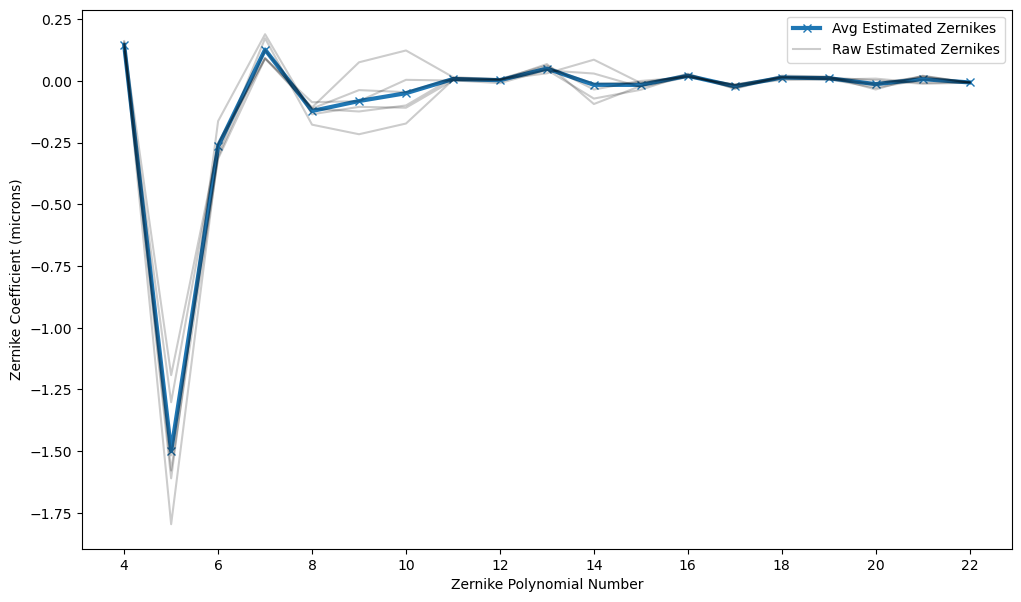

In [14]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)
plt.plot(np.arange(4,23), zernOutAvg, '-x', lw=3, label='Avg Estimated Zernikes')
plt.plot(np.arange(4,23), zernOutRaw[0], c='k', alpha=0.2, label='Raw Estimated Zernikes')
for i in range(1, len(zernOutRaw)):
    plt.plot(np.arange(4,23), zernOutRaw[i], c='k', alpha=0.2)
plt.legend()
plt.xlabel('Zernike Polynomial Number')
plt.ylabel('Zernike Coefficient (microns)')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

### Comparing the two `combineZernikes` tasks

As mentioned above there are currently two tasks available to run as sub-tasks that combine the Zernikes from all the donuts on a CCD (`outputZernikesRaw`) into the final set of Zernikes coefficients for the CCD (`outputZernikesAvg`). These two tasks and how they work are:
* `CombineZernikesMeanTask `
    * Combines coefficients for each donuts with an unweighted mean
* `CombineZernikesSigmaClipTask`
    * Calculates the unweighted mean after masking out donuts that have Zernike coefficients more than `sigma` standard deviations outside the mean value of all donuts for any of the `maxZernClip` highest order coefficients.

#### Setting up the tasks

All subtasks are also tasks that can be run on their own. Here we set up and run the two `combineZenikes` tasks to compare the output.

`CombineZernikesMeanTask` has no configuration settings.

In [15]:
meanCombineTask = CombineZernikesMeanTask()

`CombineZernikesSigmaClipTask` has the following configuration settings:

* `sigma`: This sets the number of standard deviations for the clipping limit. At each Zernike coefficient if a donut has a value greater than `sigma` standard deviations away from the mean of the other donut values then that donut is not included when averaging all Zernikes. The default value of `sigma` is 3.

* `maxZernClip`: This values sets the number of Zernikes to look at when clipping. This parameter exists since any large issues that would indicate a catastrophic outlier are usually visible in the first few coefficients and in a small sample size there can be large values of noise in the higher coefficients that would rule out a valid donut. Since we start with the 4th order Zernike the default `maxZernClip` value of 3 means we look at deviations in the 4th-6th Zernike coefficients.

In [16]:
sigmaClipConfig = CombineZernikesSigmaClipTaskConfig()
print(sigmaClipConfig)

{'sigma': 3.0, 'maxZernClip': 3}


In [17]:
sigmaClipCombineTask = CombineZernikesSigmaClipTask(config=sigmaClipConfig)

#### Run each task

Now we can run each task by simply using the `run` function provided in every task.

In [18]:
meanZerns = meanCombineTask.run(zernOutRaw)
sigmaClipZerns = sigmaClipCombineTask.run(zernOutRaw)

We can see that the information on how many pairs of donuts make it into the final calculation is printed out and when this task is run as a pipeline task this information is stored in the butler as part of the task metadata.

In [19]:
taskMetadata = butler.get('calcZernikesTask_metadata', dataId=dataIdExtra, collections=['u/brycek/ts_analysis_notebooks/wep_v8.0.3'])

In [20]:
taskMetadata['calcZernikesTask:combineZernikes']

TaskMetadata(scalars={'numDonutsTotal': 6.0, 'numDonutsUsed': 6.0, 'numDonutsRejected': 0.0}, arrays={'combineZernikesFlags': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, metadata={})

#### Example with additional outliers

The dataset included above did not have any clear outliers so let's add in a couple outliers to the original data to see more clearly how the results differ between the two methods.

In [21]:
np.std(zernOutRaw, axis=0)

array([0.01476453, 0.20024002, 0.05136383, 0.04029387, 0.02861392,
       0.08860117, 0.09486918, 0.00532924, 0.00556913, 0.01252021,
       0.06059299, 0.01211238, 0.00515263, 0.00714212, 0.00542577,
       0.00473574, 0.01567657, 0.01317352, 0.00095518])

In [46]:
rng = np.random.RandomState(seed=324)
zernOutRawOutlier = np.concatenate(
    [zernOutRaw, 
     [
         zernOutAvg * 2, 
         zernOutAvg  * -2
     ]
    ]
)

In [47]:
meanZerns = meanCombineTask.run(zernOutRawOutlier)
sigmaClipZerns = sigmaClipCombineTask.run(zernOutRawOutlier)

#### Examine Output

* `CombinedZernikes`: This the unweighted mean value of the Zernikes coefficients calculated with all the accepted donuts. 

* `Flags`: This array shows which donuts were flagged and rejected based upon their Zernike coefficient in the first `maxZernClip` Zernike coefficients. A value of 1 shows that a flag was raised and this donut was rejected. All donuts with 0 in the flags array were used to calculated the final `combinedZernikes` array. As shown above this flags array is saved in the butler task metadata for later retrieval.

In [49]:
meanZerns

Struct(combinedZernikes=[ 0.10921195 -1.12469174 -0.19827555  0.09554802 -0.09104532 -0.06076169
 -0.03696614  0.00612494  0.00251468  0.03801727 -0.01153865 -0.0117543
  0.01602109 -0.01606942  0.01057213  0.00861965 -0.00944996  0.00576098
 -0.0042536 ]; flags=[0 0 0 0 0 0 0 0])

In [50]:
sigmaClipZerns

Struct(combinedZernikes=[ 0.14561594 -1.49958899 -0.26436741  0.12739736 -0.12139375 -0.08101559
 -0.04928819  0.00816659  0.00335291  0.0506897  -0.01538486 -0.0156724
  0.02136146 -0.0214259   0.01409617  0.01149287 -0.01259995  0.0076813
 -0.00567147]; flags=[0 0 0 0 0 0 1 1])

#### Load true zernikes from OPD

In [54]:
opd_hdu = fits.open('/sdf/group/rubin/repo/aos_imsim/brycek/ts_analysis_notebooks_supporting_data/opd_000034.fits')
header = opd_hdu[0].header
true_zern = []
for zern_num in range(4, 23):
    true_zern.append(header[f'AZ_{zern_num:03}'])
true_zern = np.array(true_zern) * 1e-3

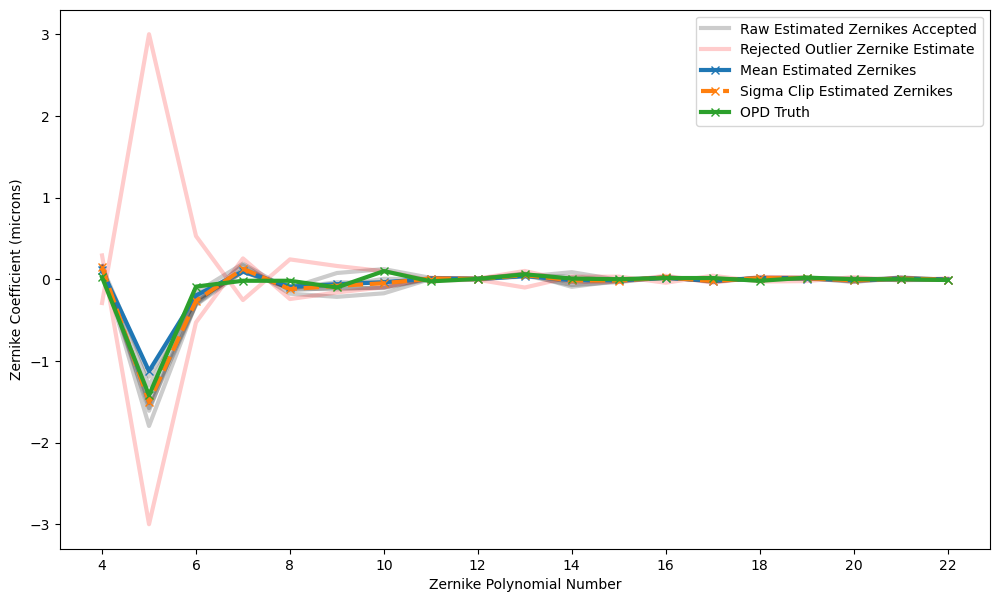

In [56]:
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(1,1,1)
acceptedLabelSet = False
for i in np.where(sigmaClipZerns.flags == 0)[0]:
    if not acceptedLabelSet:
        plt.plot(np.arange(4,23), zernOutRawOutlier[i], c='k', alpha=0.2, lw=3, label='Raw Estimated Zernikes Accepted')
        acceptedLabelSet = True
    else:
        plt.plot(np.arange(4,23), zernOutRawOutlier[i], c='k', alpha=0.2, lw=3)
        
rejectedLabelSet = False
for i in np.where(sigmaClipZerns.flags == 1)[0]:
    if not rejectedLabelSet:
        plt.plot(np.arange(4,23), zernOutRawOutlier[i], c='r', alpha=0.2, lw=3, label='Rejected Outlier Zernike Estimate')
        rejectedLabelSet = True
    else:
        plt.plot(np.arange(4,23), zernOutRawOutlier[i], c='r', alpha=0.2, lw=3)

plt.plot(np.arange(4,23), meanZerns.combinedZernikes, '-x', lw=3, label='Mean Estimated Zernikes')
plt.plot(np.arange(4,23), sigmaClipZerns.combinedZernikes, '--x', lw=3, label='Sigma Clip Estimated Zernikes')
plt.plot(np.arange(4,23), true_zern, '-x', lw=3, label='OPD Truth')
plt.legend()
plt.xlabel('Zernike Polynomial Number')
plt.ylabel('Zernike Coefficient (microns)')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [57]:
# Calculate RMSE of each combined Zernike estimate compared to the OPD value
rmse_mean = np.sqrt(np.mean((meanZerns.combinedZernikes-true_zern)**2.))
rmse_sigmaClip = np.sqrt(np.mean((sigmaClipZerns.combinedZernikes-true_zern)**2.))
print('RMSE compared to OPD:')
print(f'Mean Estimate: {rmse_mean} microns')
print(f'Sigma Clip Estimate: {rmse_sigmaClip} microns')

RMSE compared to OPD:
Mean Estimate: 0.08839371626120161 microns
Sigma Clip Estimate: 0.07642121635516907 microns


Here we see that the outlier Zernikes we added are not included in the final `sigmaClip` estimation. Once the donuts are flagged based upon their outlier values in the first `maxZernClip` Zernike coefficients then they are not used in any of the Zernike calculations afterward. We can see this effect by noticing that all Zernikes are slightly different from the mean function values. 

The Root-Mean-Squared Estimate (RMSE) is a measure of the scatter and thus measures the mean departure from the true OPD value in the Zernike estimates. We see that the RMSE value from sigma clipping is approximately half that of the original value due to the exclusion of the large outliers. This shows how the sigma clipping improves the Zernike estimation by keeping Zernike estimates that are closer to the OPD truth values.

### Running as a pipeline task

This notebooks showed how to run `CalcZernikesTask` interactively. To run in a full Gen3 processing pipeline you can use `CalcZernikesTask` and set the configuration with a pipeline file. An example of a pipeline file that runs the full pipeline up starting from `raw` files up to `CalcZernikesTask` looks like the following:

```
# This yaml file is used to define the tasks and configuration of
# a Gen 3 pipeline used for testing in ts_wep.
description: wep basic processing test pipeline
# Here we specify the corresponding instrument for the data we
# will be using.
instrument: lsst.obs.lsst.LsstCam
# Use imported instrument configuration
imports:
  - location: $TS_WEP_DIR/policy/cwfs/instData/lsst/instParamPipeConfig.yaml
# Then we can specify each task in our pipeline by a name
# and then specify the class name corresponding to that task
tasks:
  isr:
    class: lsst.ip.isr.isrTask.IsrTask
    # Below we specify the configuration settings we want to use
    # when running the task in this pipeline. Since our data doesn't
    # include bias or flats we only want to use doApplyGains and
    # doOverscan in our isr task.
    config:
      connections.outputExposure: 'postISRCCD'
      doBias: False
      doVariance: False
      doLinearize: False
      doCrosstalk: False
      doDefect: False
      doNanMasking: False
      doInterpolate: False
      doBrighterFatter: False
      doDark: False
      doFlat: False
      doApplyGains: True
      doFringe: False
      doOverscan: True
      python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'
  generateDonutCatalogWcsTask:
    class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
    config:
      connections.refCatalogs: 'ps1_pv3_3pi_20170110'
  cutOutDonutsCwfsTask:
    class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask
    config:
      # And here we specify the configuration settings originally defined in
      # CutOutDonutsCwfsTaskConfig.
      # Test with default instrument configuration parameters
      donutTemplateSize: 160
      donutStampSize: 160
      initialCutoutPadding: 40
  calcZernikesTask:
    class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
```

And a possible entry on the command line would be:

`pipetask run -b $PATH_TO_BUTLER_REPO -i $COLLECTION_NAMES -d "exposure in ($EXPOSURE_IDS)" -p $PIPELINE_CONFIGURATION_FILE --instrument lsst.obs.lsst.LsstCam  --register-dataset-types --output-run $OUTPUT_RUN_NAME `

* `-b` points to your repository
* `-i` names the collections where your calibration and raw data are located in the repository
* `-d` specify a data selection query here
* `-p` the path to the configuration file like the sample above
* `--instrument` specify the instrument for your data
* `--register-dataset-types` registers any dataset types that don't already exist in the registry
* `--output-run` specifies the name of the new output collection